In [1]:
import seaborn as sns
import pylab
import pandas as pd
import numpy as np
import datetime
pd.options.mode.chained_assignment = None 

FIGS_FOLDER = 'figs/sl'
# column names
FINAL_PERF = 'Final/Average Final Performance'
RUNTIME = 'Final/Runtime (seconds)'
LOG_RUNTIME = 'Log Runtime (seconds)'
SETTING = 'setting'
METHOD = 'method_full_name'
DATASET='dataset'

In [2]:
# some functions

def pareto_filtering(d, methods):
    N=10
    lin_interpolations = np.linspace(0, 0.5, N, endpoint=False)
    to_keep = []

    for method in methods:

        if len(d[d[METHOD]==method])==0:
            continue

        # normalize scores
        d['normalized_runtime'] = -2*(d[LOG_RUNTIME] / d[d[METHOD]==method][LOG_RUNTIME].max()) +1

        for interp in lin_interpolations:

            d['cl_score'] =  (1-interp) * d[FINAL_PERF] + interp * d['normalized_runtime']

            max_idx = d[d[METHOD]==method]['cl_score'].idxmax()
            to_keep.append(max_idx)

    return d.loc[to_keep,:]

def mscatter(x,y, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

# Reading Data

In [3]:
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("sequoia/csl_study")
summary_list = [] 
config_list = [] 
name_list = [] 
for run in runs: 
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict) 

    # run.config is the input metrics.
    # We remove special values that start with _.
    config = {k:v for k,v in run.config.items() if not k.startswith('_')}
    config_list.append(config) 

    # run.name is the name of the run.
    name_list.append(run.name)       

import pandas as pd 
summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 

## remove duplicate columns
config_df = config_df.drop('method', 1)
config_df = config_df.drop('setting', 1)

all_df = pd.concat([name_df, config_df,summary_df], axis=1)

# all_df.to_csv("project.csv")


_____________

# Clean up
0. clean up
1. Renames duplicate settings
2. Removes PNN + Class_incremental
3. Rename methods
4. rename datasets
5. rename settings

In [4]:
## 0. clean up
data = all_df.copy()

# remove crashed runs
data = data.dropna(subset=[FINAL_PERF])

# create log scale Runtime
data[LOG_RUNTIME] = np.log10(data[RUNTIME])

## 1) rename duplicate settings
## this shouldn't need to be run if we ran Fabrice cleaning script prior
settings = data[SETTING].values
for i, setting in enumerate(settings):
    if setting == 'incremental_sl':
        settings[i] = "class_incremental"
    elif setting == 'task_incremental_sl':
        settings[i] = "task_incremental"
    elif setting == "multi_task_sl":
        settings[i] = "multi_task"
    elif setting in ["iid", "traditional_sl"]:
        settings[i] = "traditional"
data[SETTING] = settings

## 2) PNN in class-incremental is random and Replay 
data[(data[METHOD] == 'pnn') & (data[SETTING] == 'class_incremental')] = np.nan
data[(data[METHOD] == 'experience_replay') & (data[SETTING] == 'task_incremental')] = np.nan

## 3) rename methods 

_for_ewc = data['hparams/ewc/coefficient'].values

methods = data[METHOD].values
## TODO(turn this into a map instead of a loop)
for i, method in enumerate(methods):
    if method == 'avalanche.lwf':
        methods[i] = "Avalanche.LWF"
    if method == 'avalanche.synaptic_intelligence':
        methods[i] = "Avalanche.SI"
    if method == 'base':
        methods[i] = "BaseMethod"
    if method == 'avalanche.gdumb':
        methods[i] = "Avalanche.GDumb"
    if method == 'avalanche.gem':
        methods[i] = "Avalanche.GEM"
    if method == 'avalanche.agem':
        methods[i] = "Avalanche.AGEM"        
    if method == 'base.ewc':
        methods[i] = "BaseMethod.EWC"
    if method == 'avalanche.ewc':
        methods[i] = "Avalanche.EWC"        
    if method == 'avalanche.cwr_star':
        methods[i] = "Avalanche.CWR*" 
    if method == 'experience_replay':
        methods[i] = "Replay" 
    if method == 'avalanche.replay':
        methods[i] = "Avalanche.Replay" 
    if method == 'pnn':
        methods[i] = "PNN"   
    if method == 'hat':
        methods[i] = "HAT" 
data[METHOD] = methods

## 4) rename datasets
datasets = data[DATASET].values
for i, dataset in enumerate(datasets):
    if dataset == 'mnist':
        datasets[i] = "MNIST"
    elif dataset == 'cifar10':
        datasets[i] = 'CIFAR10'
    elif dataset == 'cifar100':
        datasets[i] = 'CIFAR100'
    elif dataset == 'synbols':
        datasets[i] = 'Synbols'
data[DATASET] = datasets
        
## 5) rename settings
settings = data[SETTING].values
for i, setting in enumerate(settings):
    if setting == 'task_incremental':
        settings[i] = "Task-Incremental"
    elif setting == 'class_incremental':
        settings[i] = "Class-Incremental"
      
data[SETTING] = settings

In [5]:
# assert
methods = list(set(data[METHOD]))
print(methods)

datasets = list(set(data[DATASET]))
print(datasets)

settings = list(set(data[SETTING]))
print(settings)

[nan, 'Avalanche.LWF', 'Avalanche.GDumb', 'BaseMethod.EWC', 'random_baseline', 'PNN', 'HAT', 'BaseMethod', 'Avalanche.AGEM', 'Avalanche.GEM', 'Replay', 'Avalanche.EWC', 'Avalanche.SI', 'Avalanche.CWR*', 'Avalanche.Replay']
[nan, 'MNIST', 'CIFAR100', 'Synbols', 'CIFAR10']
[nan, 'Task-Incremental', 'multi_task', 'traditional', 'Class-Incremental']


# scatter plot

zsh:1: no matches found: .figs/sl/*.pdf
Task-Incremental 	 MNIST


<ipython-input-7-a30534f8ec84>:84: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pylab.xlim([x.min() - xoffset, x.max() + xoffset])


Task-Incremental 	 Synbols


<ipython-input-7-a30534f8ec84>:84: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pylab.xlim([x.min() - xoffset, x.max() + xoffset])


Task-Incremental 	 CIFAR10


<ipython-input-7-a30534f8ec84>:84: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pylab.xlim([x.min() - xoffset, x.max() + xoffset])


Class-Incremental 	 MNIST


<ipython-input-7-a30534f8ec84>:84: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pylab.xlim([x.min() - xoffset, x.max() + xoffset])


Class-Incremental 	 Synbols


<ipython-input-7-a30534f8ec84>:84: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pylab.xlim([x.min() - xoffset, x.max() + xoffset])


Class-Incremental 	 CIFAR10


<ipython-input-7-a30534f8ec84>:84: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pylab.xlim([x.min() - xoffset, x.max() + xoffset])


2021-10-04_19:22


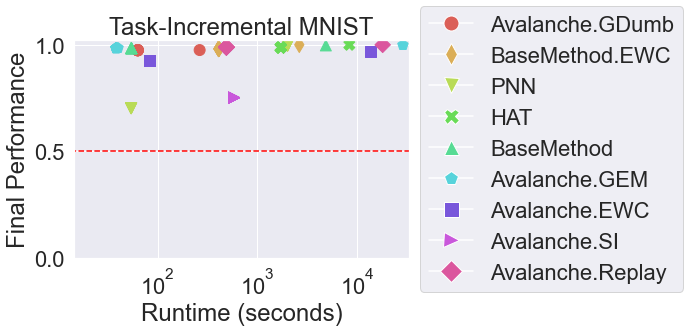

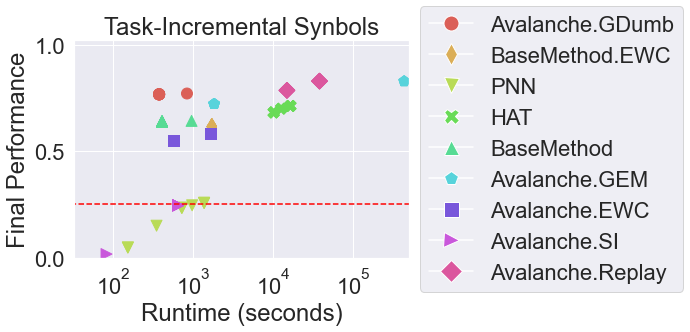

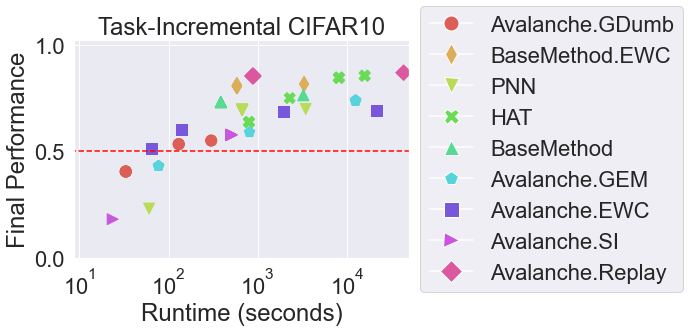

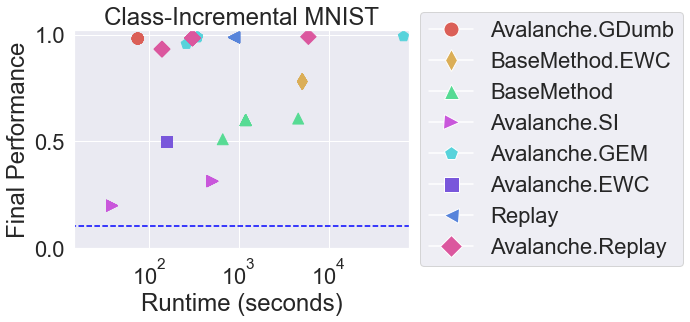

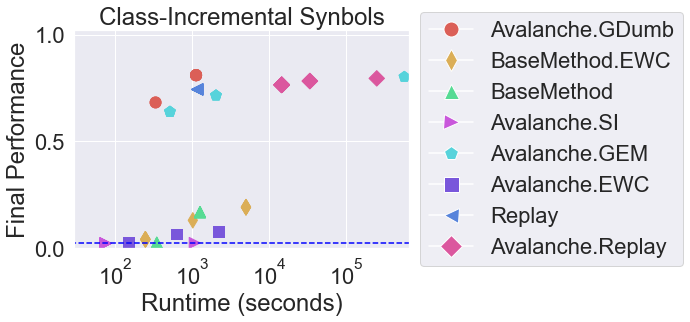

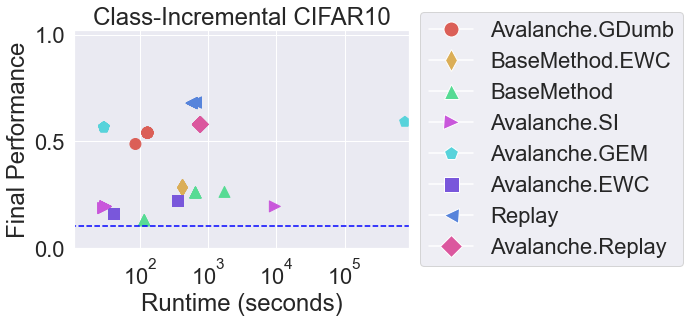

In [7]:
!rm .figs/sl/*.pdf # cleanup existing pdfs in folder
from matplotlib.lines import Line2D # import necessary for the legend
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)  # crazy big


pylab.close('all') # close all open figures

settings = data[SETTING].unique() # get list of all possible settings datasets and methods
datasets = list(set(data['dataset'].unique()))
datasets.remove('CIFAR100')

methods = list(set(data[METHOD])) 
methods.remove('random_baseline') # not interesting
methods.remove('Avalanche.CWR*') # doesn't achieve good enough performance
methods.remove('Avalanche.LWF') # doesn't achieve good enough performance
# methods.remove('Replay') 
# methods.remove('EWC')
methods.remove('Avalanche.AGEM') # doesn't work
methods = [x for x in methods if str(x) != 'nan']

colors = sns.color_palette('hls', len(methods)) # assign a color to each method
markers = ['o', 'd','v', 'X','^', 'p','<', 's', '>','D'] # assign a marker to each method

# data['Final/Runtime (seconds)'] /= data['Final/Runtime (seconds)'].std() # standarize bubble size

time = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M") # get current timestamp to save files

# loop over settings and datasets, each one is a plot
for setting in settings:
    if setting in [np.nan, 'traditional', 'multi_task']:
        continue
    
    for dataset in datasets:
        if dataset is np.nan:
            continue
        
        print(f"{setting} \t {dataset}")
        d = data[(data[SETTING] == setting) & (data['dataset'] == dataset)] # filter by settings and dataset
        # pareto filtering
        d = pareto_filtering(d, methods)
        
        # obtain values to plot
        x = d[RUNTIME].values
        y = d[FINAL_PERF].values
#         z = d['Final/Runtime (seconds)'].values
        
            
        fig, ax = pylab.subplots() # create axis
#         z = z * 1000 # make the bubbles bigger
        m = [methods.index(_m) for _m in d[METHOD].values] # map method string to integer id
        c = [colors[_m] for _m in m] # use the integer id to get the corresponding color
        _markers = [markers[_m] for _m in m] # use the integer id to get the corresponding marker
        
#         ax.scatter(x, y, s=120, c=c, alpha=1, marker=marker) # plot
        mscatter(x, y, c=c, s=120, alpha=1, m=_markers) # plot using func w/ markers
        ax.set_xscale('log')
        
        ## add random reference
        n_classes = {'Synbols':48, 'MNIST':10, 'CIFAR10':10}
        n_tasks = {'Synbols':12, 'MNIST':5, 'CIFAR10':5}
        random_acc = 1/n_classes[dataset]
        random_x = [0, 1e10]
        if setting == 'Class-Incremental':
            random_y = [random_acc, random_acc]
            plt.plot(random_x, random_y, '--', c='blue')
        if setting == 'Task-Incremental':
            random_acc *= n_tasks[dataset]
            random_y = [random_acc, random_acc]
            plt.plot(random_x, random_y, '--', c='red')
        
        ## make legend and format axis
        legend_elements = [Line2D([0], [0], color='w', label=_m,
                           marker=markers[methods.index(_m)], 
                           markerfacecolor=colors[methods.index(_m)],
                           markersize=15, alpha=1) for _m in set(d[METHOD].values)
        ]        
        xoffset = np.abs(x.max() - x.min()) * 0.15
#         yoffset = np.abs(y.max() - y.min()) * 0.05
#         pylab.xlim([x.min() - xoffset, x.max() + xoffset])
#         pylab.ylim([y.min() - yoffset, y.max() + yoffset])
        pylab.xlim([x.min() - xoffset, x.max() + xoffset])
        pylab.ylim([0, 1.02])

        
#         ax.legend(handles=legend_elements, loc='lower right')
#         ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        pylab.xlabel("Runtime (seconds)")
        pylab.ylabel("Final Performance")
        pylab.title(f'{setting} {dataset}')
        pylab.savefig(f"{FIGS_FOLDER}/setting={setting}_dataset={dataset}.pdf", bbox_inches="tight")
        ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        pylab.savefig(f"{FIGS_FOLDER}/setting={setting}_dataset={dataset}_legend.pdf", bbox_inches="tight")
        
print(time)

_______________

### Debugging: Only plot certain methods (deprecated?)

In [ ]:
!rm .figs/*.pdf # cleanup existing pdfs in folder
from matplotlib.lines import Line2D # import necessary for the legend

import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)  # crazy big


pylab.close('all') # close all open figures

settings = data['setting'].unique() # get list of all possible settings datasets and methods
datasets = list(set(data['dataset'].unique()))
datasets.remove('Cifar100')

methods = list(set(data['method']))
methods.remove('random_baseline')
methods = ['Avalanche.AGEM']
methods = [x for x in methods if str(x) != 'nan']

colors = sns.color_palette('hls', len(methods)) # assign a color to each method

# data['Final/Runtime (seconds)'] /= data['Final/Runtime (seconds)'].std() # standarize bubble size

time = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M") # get current timestamp to save files

# loop over settings and datasets, each one is a plot
for setting in settings:
    if setting in [np.nan, 'iid', 'multi_task']:
        continue
    
    for dataset in datasets:
        if dataset is np.nan:
            continue
        
        print(f"{setting} \t {dataset}")
        d = data[(data['setting'] == setting) & (data['dataset'] == dataset)] # filter by settings and dataset
        # pareto filtering
        d = pareto_filtering(d, methods)
        
        # obtain values to plot
        x = d[RUNTIME].values
        y = d[FINAL_PERF].values
#         z = d['Final/Runtime (seconds)'].values
        
            
        fig, ax = pylab.subplots() # create axis
#         z = z * 1000 # make the bubbles bigger
        m = [methods.index(_m) for _m in d['method'].values] # map method string to integer id
        c = [colors[_m] for _m in m] # use the integer id to get the corresponding color
        
        ax.scatter(x, y, s=120, c=c, alpha=1) # plot
        ax.set_xscale('log')

        # make legend and format axis
        legend_elements = [
             Line2D([0], [0], marker='o', color='w', label=_m,
                          markerfacecolor=colors[methods.index(_m)], markersize=15, alpha=1) for _m in set(d['method'].values)
        ]
        xoffset = np.abs(x.max() - x.min()) * 0.15
        yoffset = np.abs(y.max() - y.min()) * 0.05

        pylab.xlim([x.min() - xoffset, x.max() + xoffset])
        pylab.ylim([y.min() - yoffset, y.max() + yoffset])
#         ax.legend(handles=legend_elements, loc='lower right')
#         ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        pylab.xlabel("Runtime (seconds)")
        pylab.ylabel("Final Performance")
        pylab.title(f'{setting}: {dataset}')
        pylab.savefig(f"{FIGS_FOLDER}/setting={setting}_dataset={dataset}.pdf", bbox_inches="tight")
        ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        pylab.savefig(f"{FIGS_FOLDER}/setting={setting}_dataset={dataset}_legend.pdf", bbox_inches="tight")
        
print(time)

In [ ]:
# d = data[(data['setting'] == setting) & (data['dataset'] == dataset)] 
# d[(d.method=='Avalanche.Replay') & (d[SETTING]=='task_incremental')][FINAL_PERF]
# data[(data.method=='Avalanche.Replay') & (data[SETTING]=='task_incremental')]['dataset'].unique()

### Try to make a spline (deprecated)

In [ ]:
!rm .figs/sl/*.pdf # cleanup existing pdfs in folder
from matplotlib.lines import Line2D # import necessary for the legend

import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)  # crazy big


pylab.close('all') # close all open figures

settings = data['setting'].unique() # get list of all possible settings datasets and methods
datasets = data['dataset'].unique()
methods = list(set(data['method']))
methods.remove('random_baseline')
methods = [x for x in methods if str(x) != 'nan']

colors = sns.color_palette('hls', len(methods)) # assign a color to each method

# data['Final/Runtime (seconds)'] /= data['Final/Runtime (seconds)'].std() # standarize bubble size

time = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M") # get current timestamp to save files

# loop over settings and datasets, each one is a plot
for setting in settings:
    if setting in [np.nan, 'iid', 'multi_task']:
        continue
    
    for dataset in datasets:
        if dataset is np.nan:
            continue
        
        print(f"{setting} \t {dataset}")
        d = data[(data['setting'] == setting) & (data['dataset'] == dataset)] # filter by settings and dataset
        # pareto filtering
        d = pareto_filtering(d, methods)
    
        
        # manually remove cartpole and plots with less than 2 bubbles
#         if len(x[x==x]) < 2 and len(y[y==y]) < 2 or 'CartPole' in data['dataset']:
#             continue
            
        fig, ax = pylab.subplots() # create axis
#         z = z * 1000 # make the bubbles bigger
        m = [methods.index(_m) for _m in d['method'].values] # map method string to integer id
        c = [colors[_m] for _m in m] # use the integer id to get the corresponding color
        
        for method in methods:
            
            # obtain values to plot
            d_ = d[d[METHOD]==method].drop_duplicates(FINAL_PERF).sort_values(FINAL_PERF)
            x = d_[RUNTIME].values
            y = d_[FINAL_PERF].values
            
            if x.size == 1:
                ax.scatter(x, y, s=120, alpha=1) # plot
                continue
            
            else:
                #define x as 200 equally spaced values between the min and max of original x 
                xnew = np.linspace(x.min(), x.max(), 200) 

                #define spline with degree k=7
                spl = make_interp_spline(x, y, k=x.size-1)
                y_smooth = spl(xnew)
                ax.plot(xnew, y_smooth)

        # make legend and format axis
        legend_elements = [
             Line2D([0], [0], marker='o', color='w', label=_m,
                          markerfacecolor=colors[methods.index(_m)], markersize=15, alpha=1) for _m in set(d['method'].values)
        ]
        xoffset = np.abs(x.max() - x.min()) * 0.15
        yoffset = np.abs(y.max() - y.min()) * 0.05

        pylab.xlim([x.min() - xoffset, x.max() + xoffset])
        pylab.ylim([y.min() - yoffset, y.max() + yoffset])
#         ax.legend(handles=legend_elements, loc='lower right')
#         ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        pylab.xlabel("Runtime (seconds)")
        pylab.ylabel("Final Performance")
        pylab.title(f'{dataset}')
        pylab.savefig(f"{FIGS_FOLDER}/sl/setting={setting}_dataset={dataset}.pdf", bbox_inches="tight")
        ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        pylab.savefig(f"{FIGS_FOLDER}/sl/setting={setting}_dataset={dataset}_legend.pdf", bbox_inches="tight")
        
print(time)

_________________________________________

# OLD -- Group data and prepare for latex table

## Helper Functions

In [ ]:
def join_mean_std(dataframe, columns, 
                  formatter=lambda x: "%04.1f\\tiny{$\\pm$%03.01f}" % (x[0] * 100, x[1] * 100),
                  axis=1):
    """ Joins two columns in pandas and formats them as a string of mean +- std
            dataframe: pandas DataFrame
            columns: the two columns to merge
            formatter: function to apply to the columns rowwise.
            axis: pandas axis where to execute the cuntion
    """
    return dataframe[columns].apply(formatter, axis=axis)

In [ ]:
# How many runs to consider for doing the mean
TOPK=5

# Group by setting and dataset, and method extracts the top5 highest values and returns the mean and std
table = data.groupby(['setting', 'dataset', 'method']).agg(mean_score=('Final/Average Final Performance', lambda x: x.nlargest(TOPK).mean()),
                                                       std_score=('Final/Average Final Performance', lambda x: np.nanstd(x.nlargest(TOPK))))

# Remove 'class_incremental' and 'task_incremental'. The values will be re-added later as 'iid'
# into iid
table = table.loc[['class_incremental', 'task_incremental']]

# Join mean and std in a +- string
table['std_score'] = join_mean_std(table, ['mean_score', 'std_score'])
table['mean_score'] = table['std_score']
table.drop(columns='std_score', inplace=True)

# Undo grouping to obtain the final flat table
table = table.reset_index().pivot(index=["setting", "dataset"], columns='method', values='mean_score')

# ADD BACK TASK_INCREMENTAL AND CLASS_INCREMENTAL as IID

# Groups by setting and dataset, extracts the top5 highest values and returns the mean and std
all_merged_table = data.groupby(['setting', 'dataset']).agg(mean_score=('Final/Average Final Performance', lambda x: x.nlargest(TOPK).mean()),
                                            std_score=('Final/Average Final Performance', lambda x: np.nanstd(x.nlargest(TOPK))))

# Join mean and std in a +- string
all_merged_table['std_score'] = join_mean_std(all_merged_table, ['mean_score', 'std_score'])
all_merged_table['mean_score'] = all_merged_table['std_score']
all_merged_table.drop(columns='std_score', inplace=True)

# From 'all_merged_table' it picks 'iid' puts it as 'class_incremental' while 'multi_task' is put as 'task_incremental'
for i, v in table.iterrows():
    if i[0] == 'class_incremental':
        table.loc[i, 'iid'] = all_merged_table.loc[('iid', i[1])].values[0]
    elif i[0] == 'task_incremental':
        table.loc[i, 'iid'] = all_merged_table.loc[('multi_task', i[1])].values[0]


# Final flatten 
flat_table = table.reset_index().replace(np.nan, 'N/A', regex=True)
flat_table.columns = flat_table.columns.rename('')
        
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(flat_table)

In [ ]:
def auto_get_columns_values(dataframe, threshold=0.5):
    """ Helper function. Returns hyperparameters and values from a dataframe. 
        hyperparameters are those values that change less often than the threshold
        args:
            dataframe: pandas DataFrame
            threshold: float. Threshold to identify an hyperparam
        return: list, list. List with hyperparameters and list with values
    """
    columns = []
    values = []
    total_len = dataframe.shape[0]
    for column in dataframe.columns:
        if np.unique(dataframe[column].values).shape[0] < threshold * total_len:
            columns.append(column)
        else:
            values.append(column)
    return columns, values

# Obtain hparams automatically
columns, values = auto_get_columns_values(flat_table, 0.6)
print("Hyperparameters:")
print(columns)
print("Results:")
print(values)


# Move 'iid' from values (results) to columns (hyperparameters).
if 'iid' in values:
    values.remove('iid')
    columns.append('iid')

# Massimo requested to remove EWC
values.remove('ewc')

# Move the random baseline to the end
values.remove('random_baseline')
values.append('random_baseline')
flat_table = flat_table[columns + values]
print("columns", columns, "values", values)


# More helper functions

def bold_best_func(dataframe, values, parse_number=lambda x: float(x.split("\\")[0])):
    """ Helper function to bold best results, it needs a parser because numbers are in format mean +- std.
        this is hacky and it should be fixed
    """
    dataframe = dataframe.copy()
    for v in values:
        dataframe[v] = dataframe[v].str.replace("N/A", "-1")
    for i, row in dataframe.iterrows():
        v = row[values]
        nums = [parse_number(x) for x in v.values]
        dataframe.loc[i][values[np.argmax(nums)]] = "\\textbf{%s}" % dataframe.loc[i][values[np.argmax(nums)]]
    for v in values:
        dataframe[v] = dataframe[v].str.replace("-1","N/A")
    return dataframe

def replace_value_list(lst, previous, new):
    """ Looks for a value in a list and replaces it for a new one. Assumes unique lists.
    """
    idx = lst.index(previous)
    lst[idx] = new
    return lst


# PANDAS2LATEX
def pandas2latex(dataframe, columns, values, multirow=True, resizebox=1.0, cell_padding='6pt', 
                 rowcolors=0, color="lightgray", hline=None, bold_best=True, rename_header={}, 
                 rename_column={}, caption="", label=""):  
    """ Converts a pandas DataFrame into latex.
        args:
            dataframe: pandas DataFrame to conver
            columns: names of the hyperparameters (str)
            values: names of the metrics (str)
            multirow: whether to group rows with the same hyperparam into a single multirow (bool)
            resizebox: resizes the table by (100 * resizebox)% in latex (float)
            cell_padding: white space between cells (str)
            rowcolors: how often to gray/white table rows (int)
            color: xcolor color to gray out (str)
            hline: put an hline everytime the most outer hyperparameter changes. 
                If 2, it will change when the first or the second most outer change. (int)
            bold_best: bold best result
            rename_header: dictionary to rename column titles (dict)
            rename_column: dictionary to rename column values. Ex: {'lr': (0.1, 'default')}, 
                            to change all the 0.1 lr values to 'default' string (dict)
            
    """
    
    df_columns = list(dataframe.columns)
    for c in df_columns:
        if c in rename_column and c in columns:
            for before, after in rename_column[c]:
                dataframe[c] = dataframe[c].str.replace(before, after)
        if c in rename_header:
            df_columns = replace_value_list(df_columns, c, rename_header[c])
            if c in columns:
                columns = replace_value_list(columns, c, rename_header[c])
            else:
                values = replace_value_list(values, c, rename_header[c])
        
    dataframe.columns = df_columns
        
    current_values = {c: dataframe[c].values[0] for c in columns}
#     print(current_values)
    current_count = {c: 0 for c in columns}
    total = []
    color_code = ""
    dataframe = bold_best_func(dataframe, values)
    for i, (idx, v) in enumerate(dataframe.iterrows()):
        rows = []
        idxmax = 0
        for j, column in enumerate(dataframe.columns):
            if rowcolors > 0:
                color_code = "\\cellcolor{white}"
            if column in current_values:
                rows.append(color_code)
                if current_values[column] != v[column]:
                    if current_count[column] > 1:
                        total[i - 1][list(columns).index(column)] = "\\multirow{-%d}{*}{%s%s}" %(current_count[column], color_code,current_values[column])
                    else:
                        total[i - 1][list(columns).index(column)] = "%s" %(current_values[column])
                    current_values[column] = v[column]
                    current_count[column] = 0    
                current_count[column] += 1
            else:
                rows.append(v[column])
        total.append(rows)
        
    for i, column in enumerate(columns):
        if current_count[column] > 1:
            total[-1][i] = "\\multirow{-%d}{*}{%s}" %(current_count[column], current_values[column])
        else:
            total[-1][i] = "%s" %current_values[column]

    body = ""
    for j, line in enumerate(total):
        cline = ""
        
        if hline is not None and j > 0 and j < len(total) - 1:
            for i, l in enumerate(line):
                if "multirow" in l:
                    cline = "\\hline"
                    break
        body += " & ".join(line) + "\\\\" + cline + "\n"

    header = ""
    header += " & ".join(list(dataframe.columns)) + "\\\\"
    preamble = ''
    if rowcolors > 0:
        preamble += "\\rowcolors{%d}{}{%s}" %(rowcolors, color)
    if cell_padding != '6pt':
        preamble += "\\setlength\\tabcolsep{%s}" %cell_padding
    latex_table = """\\begin{table}
    \\centering
    %s
    \\centerline{\\resizebox{%f\\textwidth}{!}{\\begin{tabular}{%s}
    \\toprule
    %s
    \\midrule
    %s
    \\bottomrule
    \\end{tabular}}}
    \\caption{%s}
    \\label{%s}
\\end{table}""" %(preamble, resizebox, 'l' * len(columns) + "c" * len(values) + "", header, body, caption, label)
    print(latex_table.replace("_", "\\_"))

In [ ]:
rename_header = {'synaptic_intelligence': 'SI', 'random_baseline': 'random', 'baseline': 'BaseMethod',
                'iid':'IID', 'agem': 'aGEM', 'cwr_star': 'CWRStar', 'gem': 'GEM', 'lwf':'LWF', 'pnn':'PNN', 
                 'replay':'Replay', 'setting': 'Setting', "method": 'Method', 'dataset': 'Dataset'}
rename_column = {'setting': [('class_incremental', 'CI'), ('task_incremental', 'TI')]}
pandas2latex(flat_table, columns, values, resizebox=1.25, cell_padding='1.5pt', rowcolors=1, hline=1, rename_header=rename_header, rename_column=rename_column, label="tab:cls_study")

In [ ]:
display(flat_table)

In [ ]:
a= [0,1,2]
a.insert(1,10)
a